<a href="https://colab.research.google.com/github/emanueleiacca/ADM-HW4/blob/main/DataPreparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
#movielens_20m_dataset_path = kagglehub.dataset_download('grouplens/movielens-20m-dataset')
print('Data source import complete.')


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


https://github.com/rapidsai/cudf?tab=readme-ov-file#pip

In [3]:
pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [4]:
import rmm
import cudf
rmm.reinitialize(pool_allocator=True, managed_memory=True)
print("RAPIDS cuDF is using GPU memory:", rmm.is_initialized())

RAPIDS cuDF is using GPU memory: True


In [5]:
import cupy as cp

def check_memory():
    memory_pool = cp.get_default_memory_pool()
    total_memory = cp.cuda.Device(0).mem_info[0]  # Total memory available
    used_memory = memory_pool.used_bytes()       # Memory allocated by the pool
    free_memory = total_memory - used_memory
    print(f"GPU Memory - Total: {total_memory / (1024**3):.2f} GB, Used: {used_memory / (1024**3):.2f} GB, Free: {free_memory / (1024**3):.2f} GB")

check_memory()

GPU Memory - Total: 14.65 GB, Used: 0.00 GB, Free: 14.65 GB


In [22]:
movielens_20m_dataset_path = kagglehub.dataset_download('grouplens/movielens-20m-dataset')


dataset_directory = '/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1'

for dirname, _, filenames in os.walk(dataset_directory):
    for filename in filenames:
        print(f"File trovato: {filename}")

File trovato: genome_scores.csv
File trovato: tag.csv
File trovato: movie.csv
File trovato: genome_tags.csv
File trovato: rating.csv
File trovato: link.csv


In [23]:
ratings_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/rating.csv")
links_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/link.csv")
genome_tags_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/genome_tags.csv")
genome_scores_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/genome_scores.csv")
tags_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/tag.csv")
movies_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/movie.csv")


In [8]:
check_memory()

GPU Memory - Total: 12.14 GB, Used: 0.00 GB, Free: 12.14 GB


In [9]:
print("ratings_df:",ratings_df.columns)
print("links_df:",links_df.columns)
print("genome_tags_df:",genome_tags_df.columns)
print("genome_scores_df:",genome_scores_df.columns)
print("tags_df:",tags_df.columns)
print("movies_df:",movies_df.columns)

ratings_df: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
links_df: Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')
genome_tags_df: Index(['tagId', 'tag'], dtype='object')
genome_scores_df: Index(['movieId', 'tagId', 'relevance'], dtype='object')
tags_df: Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')
movies_df: Index(['movieId', 'title', 'genres'], dtype='object')


In [10]:
import gc
rmm.reinitialize(pool_allocator=True, managed_memory=True)  # Reset GPU memory
movies_links = movies_df.merge(links_df, on="movieId", how="left")
del links_df  # Free up memory
gc.collect()
movies_links.head()

,movieId,title,genres,imdbId,tmdbId
0,1571,When the Cat's Away (Chacun cherche son chat) ...,Comedy|Romance,115856,11956
1,1572,"Contempt (Mépris, Le) (1963)",Drama,57345,266
2,1573,Face/Off (1997),Action|Crime|Drama|Thriller,119094,754
3,1574,Fall (1997),Romance,119098,37567
4,1575,Gabbeh (1996),Drama,116384,43771


In [11]:
# Merge ratings with movies
rmm.reinitialize(pool_allocator=True, managed_memory=True)  # Reset GPU memory
ratings_movies = ratings_df.merge(movies_links, on="movieId", how="left")
del ratings_df, movies_links  # Free up memory
gc.collect()
ratings_movies.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId
0,67,1136,5.0,1999-12-11 16:59:54,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy,71853,762
1,67,1196,4.0,1999-12-11 16:47:21,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,80684,1891
2,67,1197,5.0,1999-12-11 16:47:21,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,93779,2493
3,67,1198,5.0,1999-12-11 16:47:21,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,82971,85
4,67,1206,5.0,1999-12-11 17:24:50,"Clockwork Orange, A (1971)",Crime|Drama|Sci-Fi|Thriller,66921,185


In [12]:
rmm.reinitialize(pool_allocator=True, managed_memory=True)  # Reset GPU memory
# Merge genome scores with genome tags
genome_data = genome_scores_df.merge(genome_tags_df, on="tagId", how="left")
del genome_tags_df  # Free up memory
gc.collect()
genome_data.head()

,movieId,tagId,relevance,tag
0,1,81,0.05450,assassin
1,1,82,0.11100,assassination
2,1,83,0.03225,assassins
3,1,84,0.27975,astronauts
4,1,85,0.09225,atheism


In [13]:
rmm.reinitialize(pool_allocator=True, managed_memory=True)
# Merge tags with movies
tags_movies = tags_df.merge(movies_df, on="movieId", how="left")
del tags_df  # Free up memory
gc.collect()
tags_movies.head()

,userId,movieId,tag,timestamp,title,genres
0,1588,318,friendship,2010-08-28 01:08:15,"Shawshank Redemption, The (1994)",Crime|Drama
1,1588,318,inspirational,2010-08-28 01:08:22,"Shawshank Redemption, The (1994)",Crime|Drama
2,1588,318,justice,2010-08-28 01:08:30,"Shawshank Redemption, The (1994)",Crime|Drama
3,1588,318,Morgan Freeman,2010-08-28 01:08:33,"Shawshank Redemption, The (1994)",Crime|Drama
4,1588,318,prison,2010-08-28 01:08:38,"Shawshank Redemption, The (1994)",Crime|Drama


In [14]:
check_memory()

GPU Memory - Total: 9.14 GB, Used: 0.00 GB, Free: 9.14 GB


In [15]:
print("ratings_movies:",ratings_movies.columns)
print("genome_data:",genome_data.columns)
print("tags_movies:",tags_movies.columns)

ratings_movies: Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'imdbId',
       'tmdbId'],
      dtype='object')
genome_data: Index(['movieId', 'tagId', 'relevance', 'tag'], dtype='object')
tags_movies: Index(['userId', 'movieId', 'tag', 'timestamp', 'title', 'genres'], dtype='object')


In [16]:
ratings_movies = ratings_movies[["userId", "movieId", "rating", "title", "genres","timestamp"]]
genome_data = genome_data[["movieId", "tag", "relevance"]]
tags_movies = tags_movies[["userId", "movieId", "tag"]]
#Remove repeated columns

In [17]:
print("ratings_movies:",ratings_movies.info())
print("genome_data:",genome_data.info())
print("tags_movies:",tags_movies.info())

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column     Dtype
---  ------     -----
 0   userId     int64
 1   movieId    int64
 2   rating     float64
 3   title      object
 4   genres     object
 5   timestamp  object
dtypes: float64(1), int64(2), object(3)
memory usage: 1.8+ GB
ratings_movies: None
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 11709768 entries, 0 to 11709767
Data columns (total 3 columns):
 #   Column     Dtype
---  ------     -----
 0   movieId    int64
 1   tag        object
 2   relevance  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 335.2+ MB
genome_data: None
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 465426 entries, 0 to 465425
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   userId   465426 non-null  int64
 1   movieId  465426 non-null  int64
 2   tag      465426 non-null  object
dtypes: int

1.1

In [79]:
movies_df_pd = movies_df.to_pandas()
rating_df_pd=ratings_df.to_pandas()
tags_df_pd=tags_df.to_pandas()
genome_tags_df_pd=genome_tags_df.to_pandas()
genome_scores_df_pd=genome_scores_df.to_pandas()
links_df_pd=links_df.to_pandas()

In [29]:
print("\nInfo about dataset 'movies':")
print(movies_df_pd.info())

print("\nInfo about dataset 'ratings':")
print(rating_df_pd.info())


print("\nInfo about dataset 'tag':")
print(tags_df_pd.info())

print("\nInfo about dataset 'genome_tags':")
print(genome_tags_df_pd.info())


print("\nInfo about dataset  'genome_scores':")
print(genome_scores_df_pd.info())

print("\nInfo about dataset 'link':")
print(links_df_pd.info())

display(movies_df_pd.head())
display(rating_df_pd.head())
display(tags_df_pd.head())
display(genome_tags_df_pd.head())
display(genome_scores_df_pd.head())
display(links_df_pd.head())


Info about dataset 'movies':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB
None

Info about dataset 'ratings':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB
None

Info about dataset 'tag':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465426 entries, 0 to 465425
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     465426 non-null  int64 
 1   

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [30]:
print(rating_df_pd.isnull().sum())
print(movies_df_pd.isnull().sum())
print(tags_df_pd.isnull().sum())
print(links_df_pd.isnull().sum())
print(genome_scores_df_pd.isnull().sum())
print(genome_tags_df_pd.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64
movieId      0
imdbId       0
tmdbId     252
dtype: int64
movieId      0
tagId        0
relevance    0
dtype: int64
tagId    0
tag      0
dtype: int64


In [31]:
display(rating_df_pd.drop_duplicates())
display(movies_df_pd.drop_duplicates())
display(tags_df_pd.drop_duplicates())
display(links_df_pd.drop_duplicates())
display(genome_scores_df_pd.drop_duplicates())
display(genome_tags_df_pd.drop_duplicates())


,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
20000258,138493,68954,4.5,2009-11-13 15:42:00
20000259,138493,69526,4.5,2009-12-03 18:31:48
20000260,138493,69644,3.0,2009-12-07 18:10:57
20000261,138493,70286,5.0,2009-11-13 15:42:24


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18
...,...,...,...,...
465421,138446,55999,dragged,2013-01-23 23:29:32
465422,138446,55999,Jason Bateman,2013-01-23 23:29:38
465423,138446,55999,quirky,2013-01-23 23:29:38
465424,138446,55999,sad,2013-01-23 23:29:32


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
27273,131254,466713,4436.0
27274,131256,277703,9274.0
27275,131258,3485166,285213.0
27276,131260,249110,32099.0


,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675
...,...,...,...
11709763,131170,1124,0.58775
11709764,131170,1125,0.01075
11709765,131170,1126,0.01575
11709766,131170,1127,0.11450


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


In [80]:
print("\nexploring dataset 'ratings':")
display(rating_df_pd.describe())

print("\nexploring dataset'movies':")
display(movies_df_pd.describe(include='all'))

print("\nexploring dataset 'link':")
display(links_df_pd.describe())

print("\nexploring dataset'tag':")
display(tags_df_pd.describe(include='all'))

print("\nexploring dataset 'genome_scores':")
display(genome_scores_df_pd.describe())

print("\nexploring dataset'genome_tags':")
display(genome_tags_df_pd.describe(include='all'))


exploring dataset 'ratings':


,userId,movieId,rating
count,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904587e+04,9.041567e+03,3.525529e+00
std,4.003863e+04,1.978948e+04,1.051989e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.439500e+04,9.020000e+02,3.000000e+00
50%,6.914100e+04,2.167000e+03,3.500000e+00
75%,1.036370e+05,4.770000e+03,4.000000e+00
max,1.384930e+05,1.312620e+05,5.000000e+00



exploring dataset'movies':


,movieId,title,genres
count,27278.000000,27278,27278
unique,NaN,27262,1342
top,NaN,Aladdin (1992),Drama
freq,NaN,2,4520
mean,59855.480570,NaN,NaN
std,44429.314697,NaN,NaN
min,1.000000,NaN,NaN
25%,6931.250000,NaN,NaN
50%,68068.000000,NaN,NaN
75%,100293.250000,NaN,NaN



exploring dataset 'link':


,movieId,imdbId,tmdbId
count,27278.000000,2.727800e+04,27026.000000
mean,59855.480570,5.781860e+05,63846.683083
std,44429.314697,7.804707e+05,69862.134497
min,1.000000,5.000000e+00,2.000000
25%,6931.250000,7.741725e+04,15936.500000
50%,68068.000000,1.524350e+05,39468.500000
75%,100293.250000,9.062715e+05,82504.000000
max,131262.000000,4.530184e+06,421510.000000



exploring dataset'tag':


,userId,movieId,tag,timestamp
count,465426.000000,465426.000000,465426,465426
unique,NaN,NaN,38628,425255
top,NaN,NaN,sci-fi,2010-08-25 17:56:41
freq,NaN,NaN,3382,22
mean,68716.669436,32625.962088,NaN,NaN
std,41875.356143,36081.063601,NaN,NaN
min,18.000000,1.000000,NaN,NaN
25%,28780.000000,2571.000000,NaN,NaN
50%,70201.000000,7373.000000,NaN,NaN
75%,107322.000000,62248.750000,NaN,NaN



exploring dataset 'genome_scores':


,movieId,tagId,relevance
count,1.170977e+07,1.170977e+07,1.170977e+07
mean,2.584297e+04,5.645000e+02,1.164833e-01
std,3.467615e+04,3.256254e+02,1.542463e-01
min,1.000000e+00,1.000000e+00,2.500000e-04
25%,2.926000e+03,2.827500e+02,2.425000e-02
50%,6.017000e+03,5.645000e+02,5.650000e-02
75%,4.606200e+04,8.462500e+02,1.415000e-01
max,1.311700e+05,1.128000e+03,1.000000e+00



exploring dataset'genome_tags':


,tagId,tag
count,1128.000000,1128
unique,NaN,1128
top,NaN,007
freq,NaN,1
mean,564.500000,NaN
std,325.769857,NaN
min,1.000000,NaN
25%,282.750000,NaN
50%,564.500000,NaN
75%,846.250000,NaN


In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

movies_df_pd['genres'] = movies_df_pd['genres'].str.replace('|', ' ')
tfidf = TfidfVectorizer(stop_words='english')


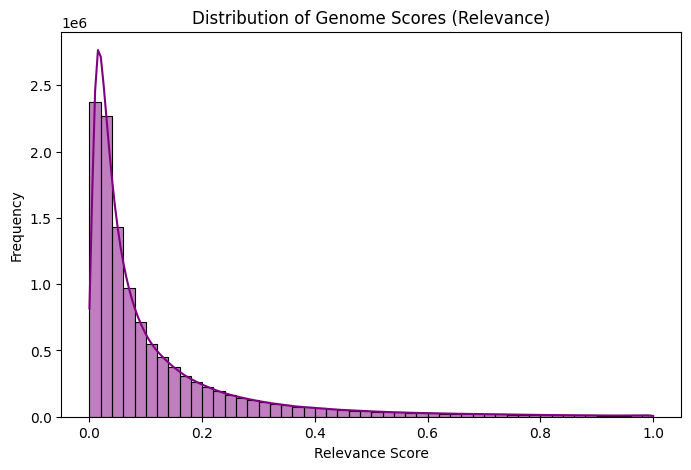

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 5))
# Convert the cudf Series to a pandas Series before plotting
sns.histplot(genome_scores_df['relevance'].to_pandas(), bins=50, kde=True, color='purple')
plt.title('Distribution of Genome Scores (Relevance)')
plt.xlabel('Relevance Score')
plt.ylabel('Frequency')
plt.show()

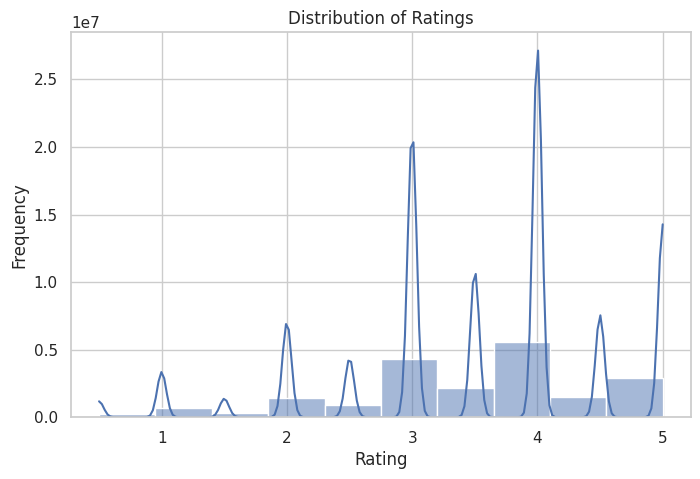

In [76]:
plt.figure(figsize=(8, 5))
sns.histplot(rating_df_pd['rating'], bins=10, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

There are noticeable peaks around ratings like 3.0, 4.0, and 5.0, suggesting that many users tend to give these scores.
Ratings below 2.0 are much less frequent.
The dataset might have a tendency towards higher ratings, indicating a positive skew (more ratings closer to 4 or 5).
Conclusion:
This distribution suggests that users tend to rate movies positively, with most ratings clustering around 3 to 5. This behavior is common in user-generated rating datasets, where extreme negative ratings are less frequent.

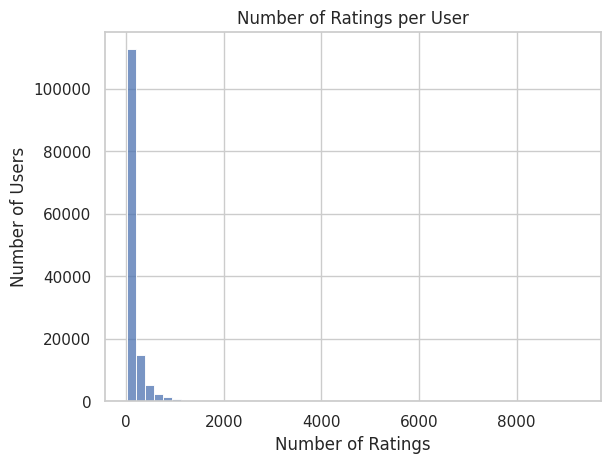

In [75]:
user_ratings_count = rating_df_pd['userId'].value_counts()
sns.histplot(user_ratings_count, bins=50, kde=False)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

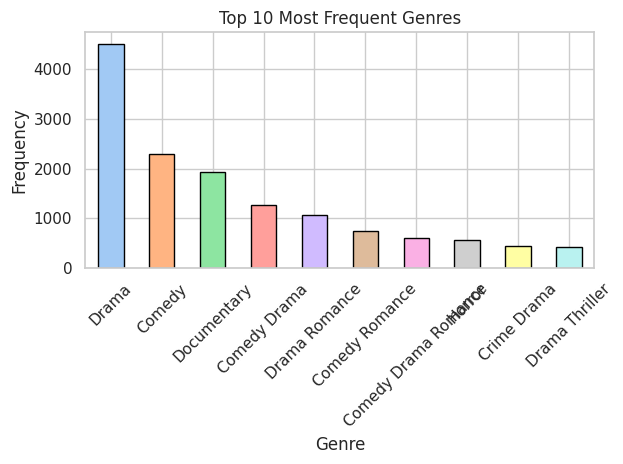

In [82]:
movies_df_pd['genres'] = movies_df_pd['genres'].dropna().astype(str).str.split('|')

# Flatten the list of genres
all_genres = [genre for sublist in movies_df_pd['genres'] for genre in sublist]

# Count genre occurrences and get the top 10
genre_counts = pd.Series(all_genres).value_counts().head(10)

# Plot with a custom Seaborn palette
sns.set(style="whitegrid")
palette = sns.color_palette("pastel", 10)

# Create the bar chart
genre_counts.plot(kind='bar', color=palette, edgecolor='black')

# Add titles and labels
plt.title('Top 10 Most Frequent Genres')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Show the plot
plt.tight_layout()  # Adjust layout to avoid cutting off labels
plt.show()

<ipython-input-67-14f2461e7f5f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_counts.values, y=tag_counts.index, palette='viridis')


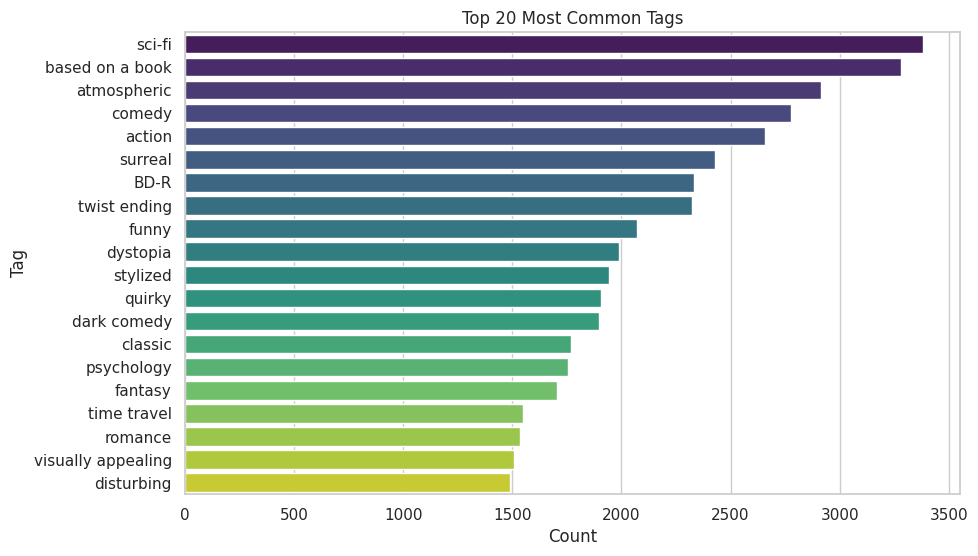

In [67]:
tag_counts = tags_df_pd['tag'].value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=tag_counts.values, y=tag_counts.index, palette='viridis')
plt.title('Top 20 Most Common Tags')
plt.xlabel('Count')
plt.ylabel('Tag')
plt.show()

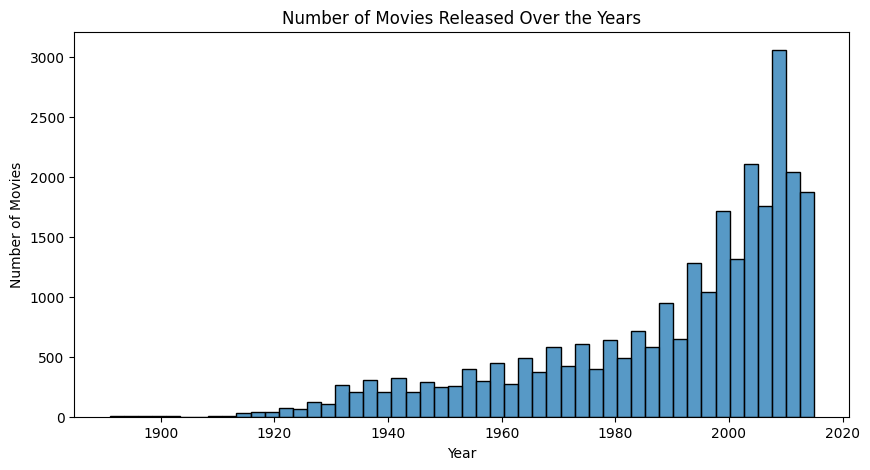

In [44]:
# Extract release year from the title (assuming format: "Movie Title (Year)")
movies_df_pd['year'] = movies_df_pd['title'].str.extract(r'\((\d{4})\)').astype(float)

# Plot movie releases by year
plt.figure(figsize=(10, 5))
sns.histplot(movies_df_pd['year'].dropna(), bins=50, kde=False)
plt.title('Number of Movies Released Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()

## 1.2 Minhash Signatures

In [46]:
user_movies = rating_df_pd.groupby('userId')['movieId'].apply(set).to_dict()

In [47]:
def jaccard_similarity_exact(movies1, movies2):
    intersection = len(movies1 & movies2)  # Intersezione degli insiemi
    union = len(movies1 | movies2)         # Unione degli insiemi
    return intersection / union if union > 0 else 0

In [48]:
def jaccard_similarity_hashed(signature1, signature2):
    matches = sum(1 for x, y in zip(signature1, signature2) if x == y)
    return matches / len(signature1)

In [49]:
def generate_hash_function(a,b,c):
    def hash_function(x):
        return (a * (x%c) + b)
    return hash_function

def generate_hash_functions(num_hashes, max_movie_id, seed=None):
    """Genera una famiglia di funzioni hash lineari."""
    if seed is not None:
        np.random.seed(seed)
    a = np.random.randint(1, max_movie_id * 2, size=num_hashes)
    b = np.random.randint(0, max_movie_id * 2, size=num_hashes)
    c = max_movie_id * 2 + 1  # Numero primo maggiore
    return [generate_hash_function(a_, b_, c) for a_, b_ in zip(a, b)]

In [50]:
def create_custom_hash_function(a_coeff, b_coeff, prime_mod):
    """Definisce una funzione hash personalizzata basata sul parametro 2x."""
    def hash_function(input_value):
        return (a_coeff * 2 * input_value + b_coeff) % prime_mod
    return hash_function

def create_hash_function_family(num_functions, max_movie_val, random_seed=None):
    """Genera una serie di funzioni hash utilizzando il coefficiente 2x nella formula."""
    if random_seed is not None:
        np.random.seed(random_seed)

    a_coefficients = np.random.randint(1, max_movie_val * 2, size=num_functions)
    b_coefficients = np.random.randint(0, max_movie_val * 2, size=num_functions)
    prime_modulo = max_movie_val * 2 + 1  # Modulo primo più grande del massimo valore

    return [create_custom_hash_function(a, b, prime_modulo) for a, b in zip(a_coefficients, b_coefficients)]

In [51]:
def create_quadratic_hash_function(coeff_a, coeff_b, prime_modulo):
    """Crea una funzione hash quadratica basata su x^2 nella formula."""
    def hash_function(input_value):
        return (coeff_a * (input_value / 2) + coeff_b * input_value) % prime_modulo
    return hash_function

def create_quadratic_hash_family(num_functions, max_val, random_seed=None):
    """Genera una famiglia di funzioni hash quadratiche."""
    if random_seed is not None:
        np.random.seed(random_seed)

    coeff_a_list = np.random.randint(1, max_val * 2, size=num_functions)
    coeff_b_list = np.random.randint(0, max_val * 2, size=num_functions)
    prime_modulo = max_val * 2 + 1  # Modulo primo maggiore del massimo valore

    return [create_quadratic_hash_function(a, b, prime_modulo) for a, b in zip(coeff_a_list, coeff_b_list)]

In [55]:
def create_cubic_hash_function(coeff_a, coeff_b, prime_mod):
    """Definisce una funzione hash cubica basata su x^3."""
    def hash_function(input_val):
        return (coeff_a * input_val**3 + coeff_b) % prime_mod
    return hash_function

def create_cubic_hash_family(num_functions, max_val, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    a_coeffs = np.random.randint(1, max_val * 2, size=num_functions)  # Coefficienti 'a'
    b_coeffs = np.random.randint(0, max_val * 2, size=num_functions)  # Coefficienti 'b'
    prime_modulo = max_val * 2 + 1  # Primo numero maggiore di max_val

    return [create_cubic_hash_function(a, b, prime_modulo) for a, b in zip(a_coeffs, b_coeffs)]

In [54]:
def generate_signatures(subset_users, user_movie_data, hash_functions):
    """Crea le firme MinHash per un gruppo specifico di utenti."""
    signatures = {}

    for user_id in subset_users:
        watched_movies = user_movie_data.get(user_id, set())

        if not watched_movies:
            # Se l'utente non ha film valutati, assegna una firma "vuota" (infinito)
            signatures[user_id] = [float('inf')] * len(hash_functions)
            continue

        user_signature = []
        for hash_func in hash_functions:
            # Trova il valore hash minimo per i film associati all'utente
            min_hash_value = min(hash_func(movie) for movie in watched_movies)
            user_signature.append(min_hash_value)

        signatures[user_id] = user_signature

    return signatures

In [56]:
def compute_mse(user_movie_data, signatures, selected_users):
    """Calcola l'errore quadratico medio (MSE) tra similarità reali e stimate per un insieme di utenti."""
    total_error = 0
    pair_count = 0

    for idx, user_a in enumerate(selected_users):
        for user_b in selected_users[idx + 1:]:
            # Similarità reale basata sulla definizione di Jaccard
            actual_jaccard = jaccard_similarity_hashed(user_movie_data[user_a], user_movie_data[user_b])

            # Similarità stimata utilizzando le firme MinHash
            estimated_jaccard = jaccard_similarity_hashed(signatures[user_a], signatures[user_b])

            # Aggiunge l'errore quadratico alla somma totale
            total_error += (actual_jaccard - estimated_jaccard) ** 2
            pair_count += 1

    # Calcola l'errore medio quadratico
    return (total_error / pair_count) if pair_count > 0 else 0

In [58]:
# Seleziona un sottoinsieme di utenti e crea il dizionario dei loro film
selected_users = list(user_movies.keys())[:100]
selected_user_movies = {user: user_movies[user] for user in selected_users}


hash_funcs_2x = create_hash_function_family(
    num_functions=10,
    max_movie_val=rating_df_pd['movieId'].max(),
    random_seed=42
)

hash_funcs_quadratic = create_quadratic_hash_family(
    num_functions=10,
    max_val=rating_df_pd['movieId'].max(),
    random_seed=42
)

hash_funcs_cubic = create_cubic_hash_family(
    num_functions=10,
    max_val=rating_df_pd['movieId'].max(),
    random_seed=42
)

# Calcola le firme MinHash per ciascun tipo di funzione hash
signatures_2x = generate_signatures(selected_users, selected_user_movies, hash_funcs_2x)
signatures_quadratic = generate_signatures(selected_users, selected_user_movies, hash_funcs_quadratic)
signatures_cubic = generate_signatures(selected_users, selected_user_movies, hash_funcs_cubic)

# Calcola l'errore quadratico medio (MSE) per ciascuna configurazione
mse_2x = compute_mse(user_movies, signatures_2x, selected_users)
mse_quadratic = compute_mse(user_movies, signatures_quadratic, selected_users)
mse_cubic = compute_mse(user_movies, signatures_cubic, selected_users)

<ipython-input-55-77d7e1577b64>:4: RuntimeWarning: overflow encountered in scalar multiply
  return (coeff_a * input_val**3 + coeff_b) % prime_mod


In [59]:

print(f"MSE  2x: {mse_2x:.4f}")

print(f"MSE  x^2: {mse_quadratic:.4f}")

print(f"MSE x^3: {mse_cubic:.4f}")

MSE  2x: 0.0081
MSE  x^2: 0.0048
MSE x^3: 0.0088


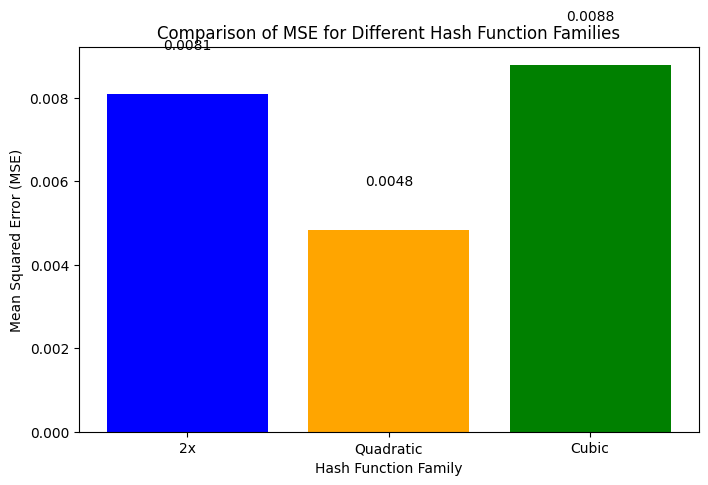

In [60]:
hash_methods = ['2x', 'Quadratic', 'Cubic']
mse_values = [ mse_2x, mse_quadratic, mse_cubic]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(hash_methods, mse_values, color=['blue', 'orange', 'green', 'red'])

# Add labels and title
plt.title('Comparison of MSE for Different Hash Function Families')
plt.xlabel('Hash Function Family')
plt.ylabel('Mean Squared Error (MSE)')

# Display MSE values on top of each bar
for i, mse in enumerate(mse_values):
    plt.text(i, mse + 0.001, f'{mse:.4f}', ha='center', va='bottom')

# Show the plot
plt.show()


In [61]:
# Calcolo delle similarità reali e stimate
real_similarities = []
estimated_similarities = []

for i, user1 in enumerate(selected_users):
    for user2 in selected_users[i+1:]:
        # Calcola la similarità reale (Jaccard)
        real_sim = jaccard_similarity_exact(user_movies[user1], user_movies[user2])
        real_similarities.append(real_sim)

        # Calcola la similarità stimata (MinHash)
        estimated_sim = jaccard_similarity_hashed(signatures_quadratic[user1], signatures_quadratic[user2])
        estimated_similarities.append(estimated_sim)

In [62]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Thresholds from 0 to 1 with step 0.1
thresholds = np.linspace(0, 1, 11)

# Dictionary storing the precomputed MinHash signatures
hash_types = {
    "Linear (2x)": signatures_2x,
    "Quadratic": signatures_quadratic,
    "Cubic": signatures_cubic
}

# Predefined MSE values for each hash type
mse_values = {
    "Linear (2x)": 0.0081,
    "Quadratic": 0.0048,
    "Cubic": 0.0088
}

# Placeholder for calculated results
results = []

# Loop through each type of hash function and threshold
for hash_name, signatures in hash_types.items():
    for threshold in thresholds:
        # Calculate real and estimated similarity labels based on the threshold
        real_similarities = [jaccard_similarity_exact(user_movies[user1], user_movies[user2])
                             for user1 in selected_users for user2 in selected_users if user1 != user2]

        estimated_similarities = [jaccard_similarity_hashed(signatures[user1], signatures[user2])
                                  for user1 in selected_users for user2 in selected_users if user1 != user2]

        # Create binary labels: 1 if similarity exceeds the threshold, else 0
        real_labels = [1 if sim >= threshold else 0 for sim in real_similarities]
        estimated_labels = [1 if sim >= threshold else 0 for sim in estimated_similarities]

        # Compute Precision, Recall, and F1-Score
        precision = precision_score(real_labels, estimated_labels, zero_division=0)
        recall = recall_score(real_labels, estimated_labels, zero_division=0)
        f1 = f1_score(real_labels, estimated_labels, zero_division=0)

        # Retrieve the MSE value for the current hash type
        mse = mse_values[hash_name]

        # Store results in a list
        results.append((hash_name, threshold, precision, recall, f1, mse))

# Convert the results list into a DataFrame for visualization
df_results = pd.DataFrame(results, columns=['Hash Type', 'Threshold', 'Precision', 'Recall', 'F1-Score', 'MSE'])

# Print the results table
print(df_results)


      Hash Type  Threshold  Precision    Recall  F1-Score     MSE
0   Linear (2x)        0.0   1.000000  1.000000  1.000000  0.0081
1   Linear (2x)        0.1   0.239758  0.757962  0.364286  0.0081
2   Linear (2x)        0.2   0.183716  0.745763  0.294807  0.0081
3   Linear (2x)        0.3   0.340000  0.472222  0.395349  0.0081
4   Linear (2x)        0.4   0.120000  0.750000  0.206897  0.0081
5   Linear (2x)        0.5   0.040000  0.333333  0.071429  0.0081
6   Linear (2x)        0.6   0.000000  0.000000  0.000000  0.0081
7   Linear (2x)        0.7   0.000000  0.000000  0.000000  0.0081
8   Linear (2x)        0.8   0.000000  0.000000  0.000000  0.0081
9   Linear (2x)        0.9   0.000000  0.000000  0.000000  0.0081
10  Linear (2x)        1.0   0.000000  0.000000  0.000000  0.0081
11    Quadratic        0.0   1.000000  1.000000  1.000000  0.0048
12    Quadratic        0.1   0.264387  0.673036  0.379641  0.0048
13    Quadratic        0.2   0.276923  0.610169  0.380952  0.0048
14    Quad

Precision: Precision measures the quality of the positive predictions made by the model. It is the ratio of true positives (TP) to the total number of predicted positives (true positives + false positives). For Default and Linear (2x), the precision is very low (0.008059), suggesting that most of the positive predictions made by the model are incorrect. For Quadratic, the precision is slightly higher (0.009174), but still very low compared to an ideal model. For Cubic, the precision is even lower (0.005491), indicating that the model is making even fewer correct predictions. Recall: Recall measures the model's ability to identify true positives, i.e., how many of the actual positives are correctly identified by the model. It is the ratio of true positives (TP) to the total number of actual positives (true positives + false negatives). For Default and Linear (2x), the recall is very high (0.923077). This indicates that the model is correctly identifying almost all true positives with very few false negatives. For Quadratic, recall drops to 0.846154, which is still good but lower than for the Default and Linear (2x) models. For Cubic, recall is even lower (0.692308), suggesting that the model is not identifying all the true positives, with a greater number of false negatives. F1-Score: F1-Score is the harmonic mean of precision and recall. It is used to balance both aspects and provide a single evaluation metric. A high F1 score indicates a good balance between precision and recall. For Default and Linear (2x), the F1-Score is very low (0.015979), reflecting the low precision despite the high recall. For Quadratic, the F1-Score is slightly higher (0.018152), indicating a better balance between precision and recall, although both scores are still low. For Cubic, the F1-Score is lower (0.010896), reflecting a poor balance between precision and recall. MSE (Mean Squared Error): MSE measures the difference between the real similarities (calculated using Jaccard) and those estimated by the model. A low MSE indicates higher accuracy in estimating similarities. For Default and Linear (2x), the MSE is 0.0081, suggesting a reasonable level of accuracy in similarity estimates, with relatively small errors between the real and estimated similarities. For Quadratic, the MSE is significantly lower (0.0048), suggesting that the similarity estimates are more accurate than in the other models. For Cubic, the MSE is slightly higher (0.0088) compared to the Default and Linear (2x) models, indicating that the similarity estimates are less precise. Summary: The Default and Linear (2x) models have a very high recall, but very low precision, suggesting that they are good at identifying positives but are not very precise in their predictions. The Quadratic model shows a trade-off between precision and recall, with an improvement in balance and a lower MSE, indicating more accurate estimates. The Cubic model has the lowest recall and lowest F1-Score, indicating that it is not as effective in detecting true positives and might not be suitable for this specific task. These results suggest that, in this case, the Default and Linear (2x) models are good at not missing positives (high recall), but with very low precision, while the Quadratic model seems to be more balanced, and the Cubic model might not be ideal.

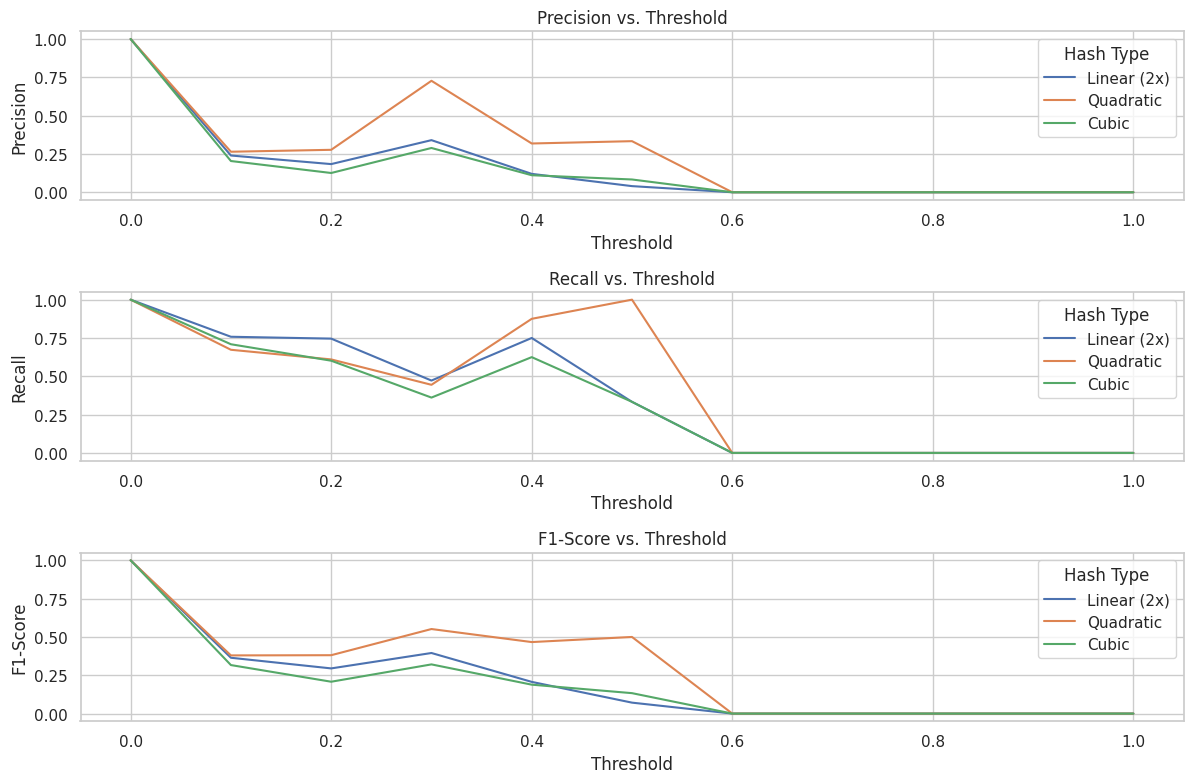

In [63]:
sns.set(style="whitegrid")

# Loop through each hash type to plot metrics vs. thresholds
metrics = ['Precision', 'Recall', 'F1-Score']
plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics):
    plt.subplot(3, 1, i + 1)  # Create subplots for each metric
    for hash_type in df_results['Hash Type'].unique():
        subset = df_results[df_results['Hash Type'] == hash_type]
        plt.plot(subset['Threshold'], subset[metric], label=hash_type)

    plt.title(f'{metric} vs. Threshold')
    plt.xlabel('Threshold')
    plt.ylabel(metric)
    plt.legend(title='Hash Type')
    plt.tight_layout()  # Adjust subplot spacing

plt.show()

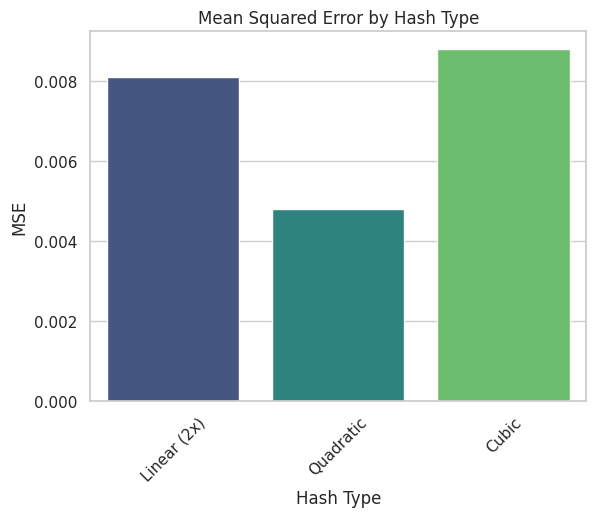

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a color palette mapping for unique hash types
unique_hash_types = df_results['Hash Type'].unique()
palette = sns.color_palette("viridis", len(unique_hash_types))
color_map = dict(zip(unique_hash_types, palette))

# Plot using 'hue' with 'legend=False'
sns.barplot(
    x='Hash Type',
    y='MSE',
    data=df_results.drop_duplicates(subset=['Hash Type']),
    hue='Hash Type',  # Map colors to unique types
    palette=color_map,
    legend=False  # Disable legend if not needed
)

plt.title('Mean Squared Error by Hash Type')
plt.xlabel('Hash Type')
plt.ylabel('MSE')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.show()


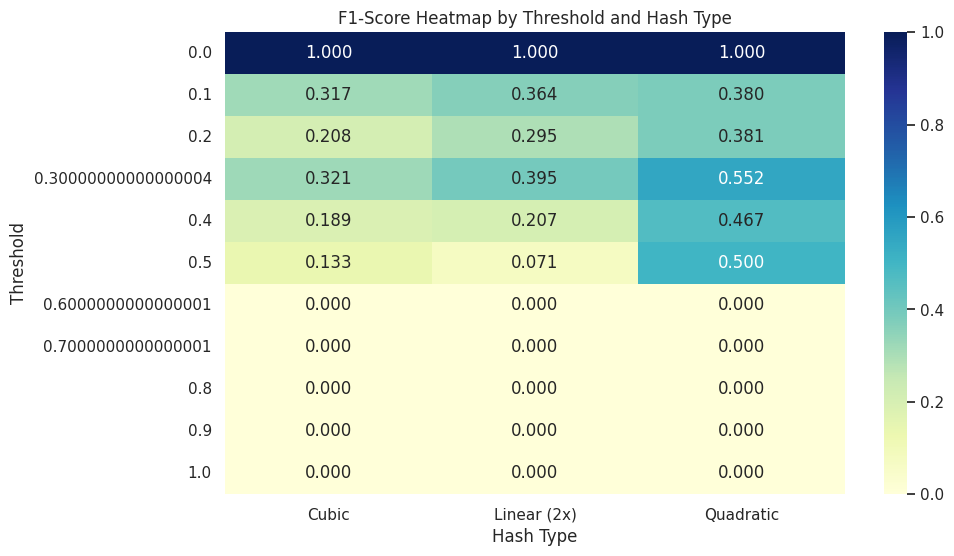

In [65]:
heatmap_data = df_results.pivot(index='Threshold', columns='Hash Type', values='F1-Score')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".3f")

# Add labels and title
plt.title('F1-Score Heatmap by Threshold and Hash Type')
plt.xlabel('Hash Type')
plt.ylabel('Threshold')
plt.show()